In [1]:
!wget "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

--2023-07-26 16:32:11--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 172.217.214.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   101MB/s    in 2.2s    

2023-07-26 16:32:13 (101 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

In [4]:
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 2s 0us/step


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


3670


In [6]:
import os
print(os.listdir(data_dir))

['sunflowers', 'LICENSE.txt', 'daisy', 'tulips', 'roses', 'dandelion']


In [7]:
print('total flower images:', len(os.listdir(data_dir)))

total flower images: 6


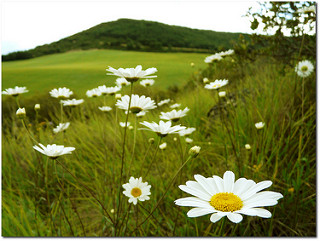

In [8]:
daisy = list(data_dir.glob('daisy/*'))
PIL.Image.open(str(daisy[2]))

Create a dataset

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Visualize the data

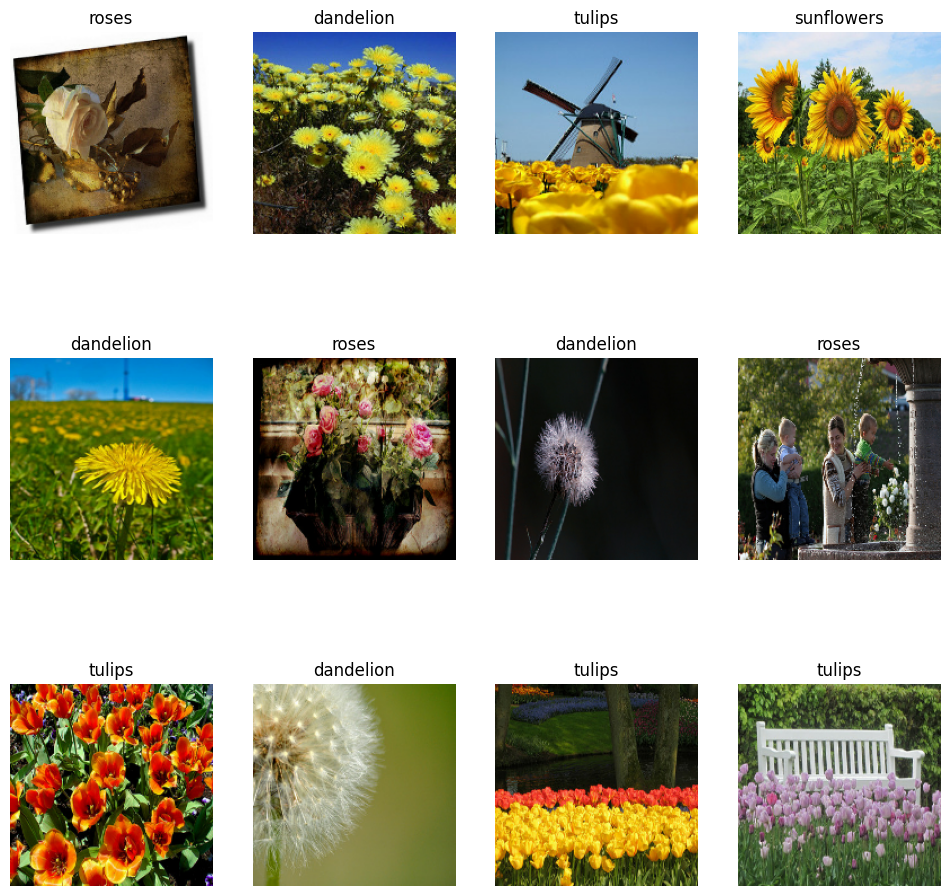

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Configure the dataset for performance

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99930793


A basic Keras model
Create the model

In [18]:
num_classes = len(class_names)
print(num_classes)

5


In [19]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Train the model

In [22]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
92/92 [==============================] - 16s 52ms/step - loss: 1.4070 - accuracy: 0.4087 - val_loss: 1.1672 - val_accuracy: 0.5136
Epoch 2/20
92/92 [==============================] - 2s 22ms/step - loss: 0.9885 - accuracy: 0.6127 - val_loss: 0.9510 - val_accuracy: 0.6185
Epoch 3/20
92/92 [==============================] - 2s 20ms/step - loss: 0.8031 - accuracy: 0.6948 - val_loss: 0.9745 - val_accuracy: 0.6253
Epoch 4/20
92/92 [==============================] - 2s 20ms/step - loss: 0.6217 - accuracy: 0.7738 - val_loss: 0.9743 - val_accuracy: 0.6308
Epoch 5/20
92/92 [==============================] - 2s 20ms/step - loss: 0.3938 - accuracy: 0.8665 - val_loss: 1.1216 - val_accuracy: 0.6253
Epoch 6/20
92/92 [==============================] - 2s 20ms/step - loss: 0.2252 - accuracy: 0.9275 - val_loss: 1.2511 - val_accuracy: 0.6403
Epoch 7/20
92/92 [==============================] - 2s 23ms/step - loss: 0.1251 - accuracy: 0.9601 - val_loss: 1.5737 - val_accuracy: 0.6185
Epoch 8/20
9